The Kaggle competition "Natural Language Processing with Disaster Tweets" centers on utilizing machine learning and NLP techniques to discern whether a tweet relates to a genuine disaster event. The aim is to develop a model capable of categorizing tweets as either disaster-related or not. The dataset provided contains labeled tweets for training purposes, along with a separate test set for evaluating the model's performance, with the F1 score serving as the competition's metric.

Natural Language Processing (NLP) constitutes a specialized branch within machine learning dedicated to teaching computers to comprehend and analyze human language. It encompasses tasks such as text segmentation, emotion recognition, and language translation. NLP integrates methods from both machine learning and linguistics to create applications like chatbots and language translation tools. Similar to image data processing, handling text data requires tailored preprocessing steps, including techniques like tokenization, which we will delve into later.

## Kaggle

Source https://www.kaggle.com/competitions/nlp-getting-started/overview

### Data

We have CSV files for both the training and test datasets, each requiring less than 1MB of disk space, which is notably compact. This size limitation ensures that we shouldn't encounter any challenges due to large data sizes. The CSV file format enables us to organize our data into a tabular structure with multiple columns, including:

* ID: a unique identifier for each tweet
* Keyword: a specific keyword mentioned in the tweet (which may be blank)
* Location: the location from which the tweet was sent (which may also be blank)
* Text: the content of the tweet
* Target: true labels indicating whether the tweet is related to a disaster (1) or not (0), available only in the training data

We will explore these columns further during the Exploratory Data Analysis (EDA) phase. Notably, the Kaggle competition description hints that some values in the Keyword and Location columns might be missing.

Furthermore, there is a sample submission file demonstrating the required format for our final submission. We need to provide both the ID of the respective test tweet and the predicted label generated by our model.

In [2]:
!pip install contractions

import contractions
import re
import string
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Bidirectional, GRU, Dense, Attention, Multiply, GlobalMaxPooling1D, LSTM
from keras.models import Sequential, Model
from keras.optimizers import Adam

max_sequence_length = 30
epochs = 20

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


### Reading Dataset

In [3]:
df_train = pd.read_csv('../input/nlp-getting-started/train.csv')
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df_test = pd.read_csv('../input/nlp-getting-started/test.csv')
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


### Word Count Distribution of Tweets

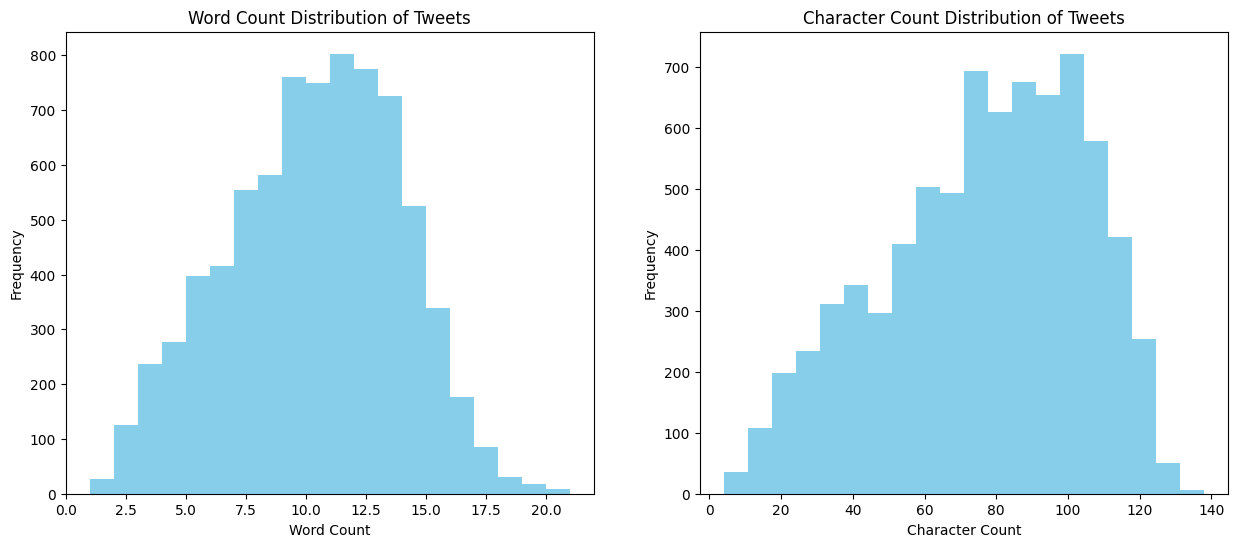

In [30]:
# Calculate word count for each tweet
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))

# Calculate character count for each tweet
df_train['char_count'] = df_train['text'].apply(len)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.hist(df_train['word_count'], bins=20, color='skyblue')
plt.title('Word Count Distribution of Tweets')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df_train['char_count'], bins=20, color='skyblue')
plt.title('Character Count Distribution of Tweets')
plt.xlabel('Character Count')
plt.ylabel('Frequency')

plt.show()

The word count distribution appears to approximate a normal distribution without notable outliers. Most tweets consist of 10 to 20 words. Additionally, we can investigate the character count distribution.

In contrast, the character count distribution does not seem to conform to a normal distribution. The majority of tweets contain approximately 140 characters.

Ensuring a balanced dataset is crucial before applying a classification model to our data. Therefore, we need to examine the **label distribution** of our training dataset.

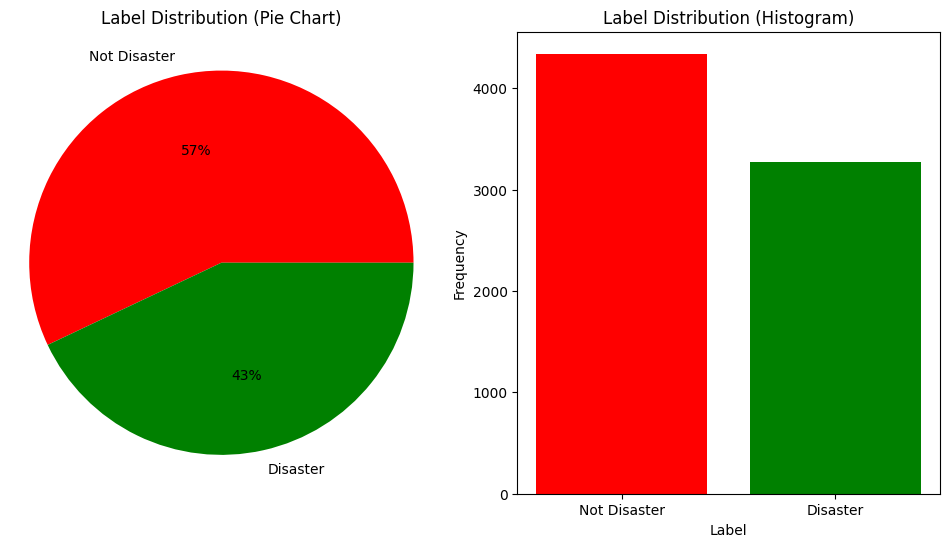

In [36]:
label_counts = df_train['target'].value_counts()
labels = ['Not Disaster', 'Disaster']

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot pie chart
axes[0].pie(label_counts, labels=labels, autopct='%1.0f%%', colors=['red', 'green'])
axes[0].set_title('Label Distribution (Pie Chart)')
axes[0].axis('equal')

# Plot histogram
axes[1].bar(label_counts.index, label_counts.values, color=['red', 'green'])
axes[1].set_title('Label Distribution (Histogram)')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks(label_counts.index)
axes[1].set_xticklabels(labels)

plt.show()

We observe that we have slightly more tweets labeled as **Not Disaster** compared to **Disaster**. As the imbalance is not significant, we will refrain from balancing our dataset for this project. Nonetheless, it's important to acknowledge that this imbalance could potentially introduce bias to our model.

## Data Cleaning

The utilization of contractions aids in accurately tokenizing text by treating each word as a distinct entity. This approach can mitigate ambiguities. For instance, the contraction **I'll** could denote either **I will** or **I shall** contingent upon the context.

Furthermore, it iss important to strip away extraneous details from our tweets. This involves removing punctuation, which does not add meaningful value to our model. We'll also eliminate English stopwords like "the" or "and," as they don't convey crucial information when discerning whether a tweet discusses a disaster. 

Additionally, our exploratory data analysis (EDA) revealed the prevalence of meaningless short words, typically comprising only 1 or 2 characters. Consequently, we will filter out words with less than 3 characters. Lastly, to ensure consistency and comparability across different tweets, we will convert all text to lowercase.

We will apply these cleaning steps to both the training & test dataset.

In [8]:
def expand_contractions(text):
    """
    Function to expand contractions in text using the contractions package.
    """
    contractions_re = re.compile('(%s)' % '|'.join(contractions.contractions_dict.keys()))
    
    def replace(match):
        return contractions.fix(match.group(0))
    
    return contractions_re.sub(replace, text)

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords_and_small(text):
    """
    Remove STOPWORDS and keep only words with more than 2 characters
    """
    return ' '.join([i for i in text.split() if i not in STOPWORDS and len(i) > 2])

In [9]:
sample_before_cleaning = df_train['text'][50]

In [10]:
# clean training data
df_train['text'] = df_train['text'].apply(lambda text: expand_contractions(text))
df_train['text'] = df_train['text'].apply(lambda text: remove_punctuation(text))
df_train['text'] = df_train['text'].apply(lambda text: remove_stopwords_and_small(text))
df_train['text'] = df_train['text'].apply(lambda text: text.lower())


# clean test data
df_test['text'] = df_test['text'].apply(lambda text: expand_contractions(text))
df_test['text'] = df_test['text'].apply(lambda text: remove_punctuation(text))
df_test['text'] = df_test['text'].apply(lambda text: remove_stopwords_and_small(text))
df_test['text'] = df_test['text'].apply(lambda text: text.lower())

In [11]:
sample_after_cleaning = df_train['text'][50]

print(f"{sample_before_cleaning = }")
print(f"{sample_after_cleaning = }")

sample_before_cleaning = 'Deputies: Man shot before Brighton home set ablaze http://t.co/gWNRhMSO8k'
sample_after_cleaning = 'deputies man shot brighton home set ablaze httptcogwnrhmso8k'


In [12]:
df_train['tokens'] = df_train['text'].apply(lambda text: word_tokenize(text))
df_test['tokens'] = df_test['text'].apply(lambda text: word_tokenize(text))

In [13]:
print(f"Clean text: { df_train['text'][50]}")
print(f"Tokenized: {df_train['tokens'][50]}")

Clean text: deputies man shot brighton home set ablaze httptcogwnrhmso8k
Tokenized: ['deputies', 'man', 'shot', 'brighton', 'home', 'set', 'ablaze', 'httptcogwnrhmso8k']


While our text preprocessing appears adequate, we still lack the appropriate format for model input. To address this, we need to utilize word embedding methods, which represent words as continuous, dense vectors in a multi-dimensional space. These word vectors enable algorithms to comprehend and process language data more efficiently.

One popular word embedding technique is Word2Vec, which learns word embeddings by training a neural network on a substantial corpus of text. This process generates dense, continuous-valued word vectors capable of capturing semantic relationships between words. While Word2Vec is versatile and applicable to various natural language processing (NLP) tasks, it tends to be more computationally intensive compared to simpler techniques like One-Hot Encoding.

In [14]:
word2vec_model = Word2Vec(df_train['tokens'].tolist(), vector_size=100, window=5, min_count=1, sg=0, workers=4)

def tokens_to_vectors(tokens, word2vec_model):
    """
    convert tokens to Word2Vec vectors
    """
    vectors = []
    for token in tokens:
        if token in word2vec_model.wv:
            vectors.append(word2vec_model.wv[token])
    return vectors

df_train['word2vec_vectors'] = df_train['tokens'].apply(lambda x: tokens_to_vectors(x, word2vec_model))
df_test['word2vec_vectors'] = df_test['tokens'].apply(lambda x: tokens_to_vectors(x, word2vec_model))

Lets split our training data into training and validation set

In [15]:
X = df_train['word2vec_vectors'] 
y = df_train['target']           

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = df_test['word2vec_vectors']

### Model Building

To construct a basic LSTM model, we first need to define a maximum sequence length. This allows us to perform padding, ensuring that we create equally long vector representations of tweets with varying lengths. Based on our exploratory data analysis (EDA), we observed that the longest tweets in our training dataset contain approximately 30 words. Therefore, we'll set the maximum sequence length parameter to this value.

In [16]:

X_train_padded = pad_sequences(X_train, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post')
X_val_padded = pad_sequences(X_val, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post')
X_test_padded = pad_sequences(X_test, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post')

We will begin by selecting a sensible learning rate and batch size and assess their effectiveness. These parameters will undergo further refinement in subsequent steps.

The model architecture consists of two LSTM layers followed by a dense output layer. The first LSTM layer processes sequences and returns sequences, whereas the second LSTM layer processes the sequence and produces a single output per sequence.

Specifically designed for binary classification tasks, the model utilizes an Adam optimizer.

In [17]:
def lstm_model(learning_rate = 0.001):
    """
    Create an LSTM model
    """
    model = Sequential()
    
    model.add(LSTM(128, input_shape=(max_sequence_length, word2vec_model.vector_size), return_sequences=True))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


lstm_history = lstm_model().fit(X_train_padded, y_train, validation_data=(X_val_padded, y_val), epochs=epochs, batch_size=32)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.5622 - loss: 0.6836 - val_accuracy: 0.5955 - val_loss: 0.6616
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.5751 - loss: 0.6740 - val_accuracy: 0.6034 - val_loss: 0.6591
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.6209 - loss: 0.6519 - val_accuracy: 0.6192 - val_loss: 0.6532
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.6474 - loss: 0.6288 - val_accuracy: 0.6316 - val_loss: 0.6430
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.6643 - loss: 0.6207 - val_accuracy: 0.6829 - val_loss: 0.6135


In [18]:
def plot_results(history, model_name):
    """
    Function to plot training and validation loss, and training and validation accuracy.
    """

    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']
    
    epochs = range(1, len(training_loss) + 1)
    
    # Plotting
    plt.figure(figsize=(12, 4))

    # training and talidation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_loss, label='Training Loss')
    plt.plot(epochs, validation_loss, label='Validation Loss')
    plt.title(model_name + ': Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_accuracy, label='Training Accuracy')
    plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
    plt.title(model_name + ': Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

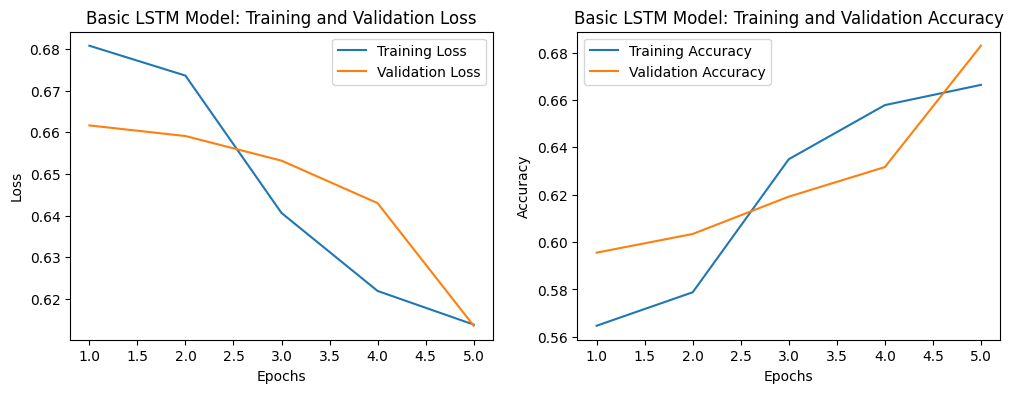

In [19]:
plot_results(lstm_history, "Basic LSTM Model")

We observe the expected trend of increasing training accuracy over epochs, accompanied by a decrease in loss. After 20 epochs, we achieve a training accuracy of approximately 70%, which is promising for an initial attempt with this basic model

To further enhance performance, we'll explore the possibility of tuning some hyperparameters. Instead of employing a predefined method like grid search, we'll develop our custom logic since we're only dealing with two hyperparameters.

In [22]:
learning_rates = [0.001, 0.01]
batch_sizes = [32, 64, 128]

best_accuracy = 0.0
best_learning_rate = None
best_batch_size = None
best_lstm_model = None
best_lstm_history = None

for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        print(f"Learning Rate : {learning_rate}, Batch Size: {batch_size}")
        
        # Train
        model = lstm_model(learning_rate=learning_rate)
        history = model.fit(X_train_padded, y_train, validation_data=(X_val_padded, y_val), epochs=epochs, batch_size=batch_size, verbose=0)
        
        # Evaluate
        accuracy = model.evaluate(X_val_padded, y_val, verbose=0)[1]
        
        print(f"\t Accuracy {accuracy}")
                
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_learning_rate = learning_rate
            best_batch_size = batch_size
            best_lstm_model = model
            best_lstm_history = history

# Print best hyperparameters
print("Best Hyperparameters:")
print(f"Learning Rate: {best_learning_rate}")
print(f"Batch Size: {best_batch_size}")
print(f"Best Validation Accuracy: {best_accuracy}")

Learning Rate : 0.001, Batch Size: 32
	 Accuracy 0.6835193634033203
Learning Rate : 0.001, Batch Size: 64
	 Accuracy 0.674983561038971
Learning Rate : 0.001, Batch Size: 128
	 Accuracy 0.6605384349822998
Learning Rate : 0.01, Batch Size: 32
	 Accuracy 0.5738673806190491
Learning Rate : 0.01, Batch Size: 64
	 Accuracy 0.5738673806190491
Learning Rate : 0.01, Batch Size: 128
	 Accuracy 0.5738673806190491
Best Hyperparameters:
Learning Rate: 0.001
Batch Size: 32
Best Validation Accuracy: 0.6835193634033203


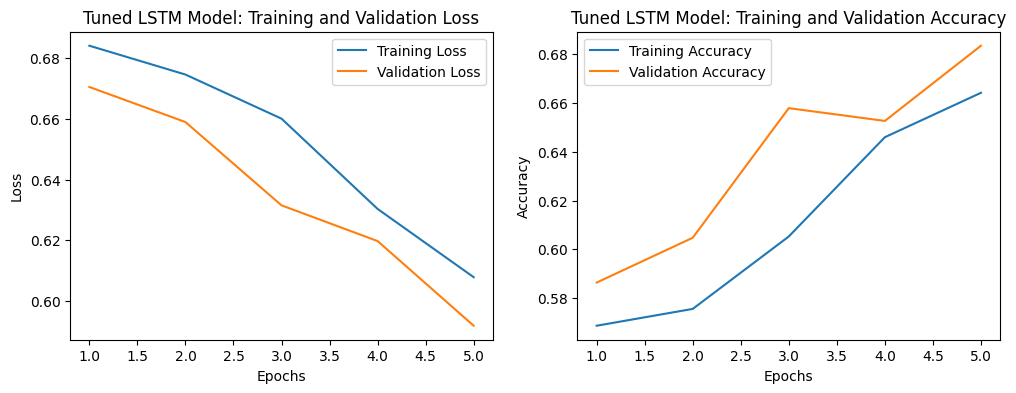

In [23]:
plot_results(best_lstm_history, "Tuned LSTM Model")

The hyperparameter tuning process did not lead to a significant improvement; the results remain largely unchanged from before. It is possible that another model architecture might yield better results. To ensure fair comparison, we'll retain the previously determined best learning rate and batch size.

We will explore a Bidirectional GRU (Gated Recurrent Unit) architecture, which extends the capabilities of a standard GRU. Unlike a simple LSTM that processes input sequences in one direction, a Bidirectional GRU can process input sequences in both forward and backward directions. This bidirectional processing enables the model to capture not only the context of each element in a sequence but also the context from both past and future elements.

In [25]:
embedding_dim = 100
hidden_units = 64

sequence_input = Input(shape=(max_sequence_length, embedding_dim), dtype='float32')


bi_gru = Bidirectional(GRU(hidden_units, return_sequences=True))(sequence_input)

attention = Attention()([bi_gru, bi_gru])
attended_gru = Multiply()([bi_gru, attention])
pooling = GlobalMaxPooling1D()(attended_gru)

output = Dense(1, activation='sigmoid')(pooling)

bigru_model = Model(inputs=sequence_input, outputs=output)

optimizer = Adam(learning_rate=best_learning_rate)
bigru_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

bigru_history = bigru_model.fit(X_train_padded, y_train, validation_data=(X_val_padded, y_val), epochs=epochs, batch_size=best_batch_size)

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.5523 - loss: 0.6885 - val_accuracy: 0.5772 - val_loss: 0.6772
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.5729 - loss: 0.6762 - val_accuracy: 0.5936 - val_loss: 0.6743
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.5847 - loss: 0.6712 - val_accuracy: 0.6211 - val_loss: 0.6592
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.6161 - loss: 0.6600 - val_accuracy: 0.6402 - val_loss: 0.6516
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.6315 - loss: 0.6450 - val_accuracy: 0.6527 - val_loss: 0.6254


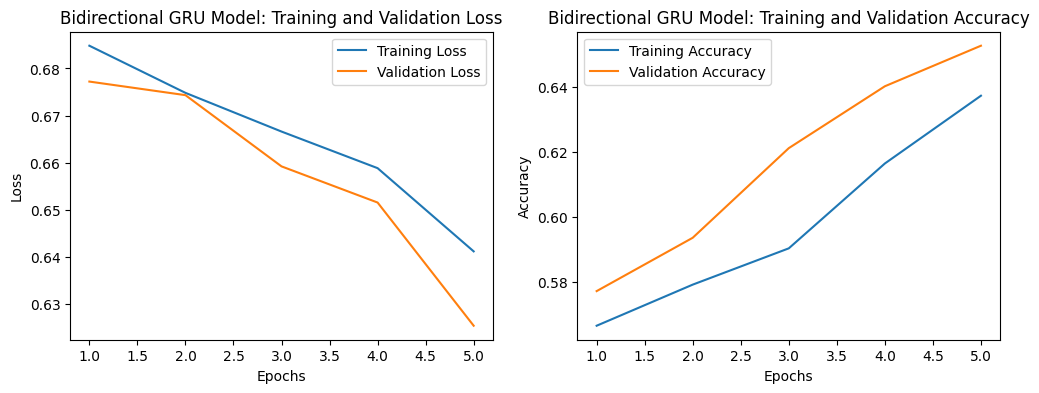

In [27]:
plot_results(bigru_history, "Bidirectional GRU Model")

The final outcomes are almost identical to those obtained with the tuned LSTM. However, it's worth noting that the LSTM reached its plateau value more quickly. We'll delve into these findings further in the next section for a detailed analysis.

### Submission file for Kaggle

In [28]:
# Predict target labels for test data
y_pred = best_lstm_model.predict(X_test_padded)
y_pred_binary = (y_pred > 0.5).astype(int)

# Create DataFrame for submission
df_submission = pd.DataFrame({'id': df_test['id'], 'target': y_pred_binary.flatten()})

# Save submission DataFrame to a CSV file
df_submission.to_csv('submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step


### Results and Analysis

Upon comparing all model graphs, it is evident that there isn't much difference in the training results. The tuning process did not seem to provide substantial improvement, only a slight enhancement. Surprisingly, the bidirectional GRU model even converged slower to a final accuracy score that is approximately the same as that of the LSTM. Based on these findings, the tuned LSTM may be the preferable choice at this juncture.

Several reasons could account for why the GRU model didn't demonstrate any improvement over the LSTM model. For instance, tasks like ours, particularly those with relatively short sequences or simple patterns, may not derive significant benefit from bidirectional modeling. Additionally, we didn't perform hyperparameter tuning with the GRU model, which could have potentially led to better results.